# Requirements

In [ ]:
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the primary objective is to use Long Short-Term Memory (LSTM) networks for time series forecasting in order to predict the future **count of page loads**. To accomplish this use data from the past three days, which includes information such as the **count of page loads**, **count of unique visits**, **count of first time-visits**, and **count of returning visits**. The goal is to employ LSTM, a type of recurrent neural network, to effectively forecast the future **count of page loads** based on the provided historical data.

## The Website Visitors Dataset

## Downloading the Website Visitors Dataset

In [ ]:
!gdown 1h1P3NboXKbWNngqgCB1i4bHFRcv7uDJe

## Exploring the Website Visitors Dataset
This datatset consists of daily counts of page loads, unique visitors, first-time visitors, and returning visitors for an academic teaching notes website. The dataset contains 2167 rows spanning from September 14, 2014, to August 19, 2020. A visit is defined as a series of hits on one or more pages by the same user on a given day, identified by IP address. Shared IP addresses are considered a single user. A visit is "unique" if a hit from the same IP address hasn't occurred within the last 6 hours. Returning visitors are identified by cookies, and the rest are classified as first-time visitors. The unique visitor count is the sum of returning and first-time visitors.

The dataset consists of the following columns:
- date - date in mm/dd/yyyy format,
- day_of_week - day of the week in text form (Monday, Tuesday, etc.),
- page_loads - daily number of pages loaded,
- unique_visits - daily number of visitors from IP addresses with no hits in over 6 hours,
- first_time_visits - number of unique visitors without a identifying cookie, and
- returning_visits - number of unique visitors minus first-time visitors.

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

array([[<Axes: title={'center': 'page_loads'}>,
        <Axes: title={'center': 'unique_visits'}>],
       [<Axes: title={'center': 'first_time_visits'}>,
        <Axes: title={'center': 'returning_visits'}>]], dtype=object)

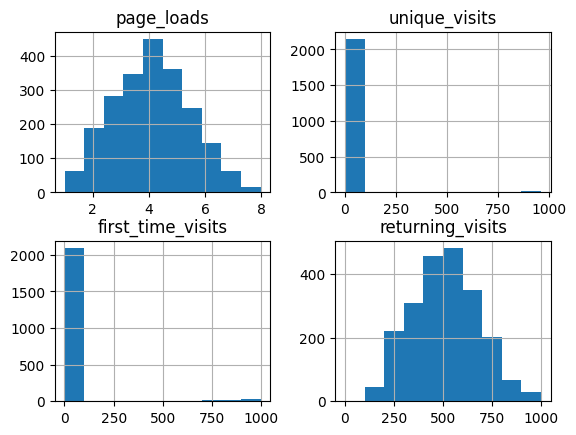

In [ ]:
# Write your code here. Add as many boxes as you need.
data = pd.read_csv('website-visitors.csv')
data.head()
data.hist()

Explore the dataset using visualizations of your choice.

In [ ]:
# Write your code here. Add as many boxes as you need.

Drop the column **day_of_week**, because we won't use it.

In [ ]:
data=data.drop(columns=['day_of_week'])
data.head()

,date,page_loads,unique_visits,first_time_visits,returning_visits
0,9/14/2014,2.146,1.582,1.430,152.0
1,9/15/2014,3.621,2.528,2.297,231.0
2,9/16/2014,3.698,2.630,2.352,278.0
3,9/17/2014,3.667,2.614,2.327,287.0
4,9/18/2014,3.316,2.366,2.130,236.0


## Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

*Be careful when extracting the features. For each day, ensure that features are obtained sequentially, starting with those from 3 days ago, followed by features from 2 days ago, and finally, features from 1 day ago. This becomes crucial when reshaping the train and test sets later on.*

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [ ]:
# Write your code here. Add as many boxes as you need.data = data.sort_values(by='date', ascending=False)
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date')
tmp=['page_loads', 'unique_visits', 'first_time_visits', 'returning_visits']
for i in range(3,0,-1):
  for t in tmp:
    data[f'{t} from {i} days ago'] = data[f'{t}'].shift(i)

tmp=['unique_visits', 'first_time_visits', 'returning_visits']
data.drop(columns=tmp, inplace=True)

data.head(10)

,date,page_loads,page_loads from 3 days ago,unique_visits from 3 days ago,first_time_visits from 3 days ago,returning_visits from 3 days ago,page_loads from 2 days ago,unique_visits from 2 days ago,first_time_visits from 2 days ago,returning_visits from 2 days ago,page_loads from 1 days ago,unique_visits from 1 days ago,first_time_visits from 1 days ago,returning_visits from 1 days ago
0,2014-09-14,2.146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-09-15,3.621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.146,1.582,1.430,152.0
2,2014-09-16,3.698,NaN,NaN,NaN,NaN,2.146,1.582,1.430,152.0,3.621,2.528,2.297,231.0
3,2014-09-17,3.667,2.146,1.582,1.430,152.0,3.621,2.528,2.297,231.0,3.698,2.630,2.352,278.0
4,2014-09-18,3.316,3.621,2.528,2.297,231.0,3.698,2.630,2.352,278.0,3.667,2.614,2.327,287.0
5,2014-09-19,2.815,3.698,2.630,2.352,278.0,3.667,2.614,2.327,287.0,3.316,2.366,2.130,236.0
6,2014-09-20,1.658,3.667,2.614,2.327,287.0,3.316,2.366,2.130,236.0,2.815,1.863,1.622,241.0
7,2014-09-21,2.288,3.316,2.366,2.130,236.0,2.815,1.863,1.622,241.0,1.658,1.118,985.000,133.0
8,2014-09-22,3.638,2.815,1.863,1.622,241.0,1.658,1.118,985.000,133.0,2.288,1.656,1.481,175.0
9,2014-09-23,4.462,1.658,1.118,985.000,133.0,2.288,1.656,1.481,175.0,3.638,2.586,2.312,274.0


In [ ]:
data.tail(5)
data.dropna(subset=data.columns,axis=0,inplace=True)


In [ ]:
data.drop('date',axis=1,inplace=True)

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [ ]:
# Write your code here. Add as many boxes as you need.
X, Y = data.drop('page_loads',axis=1), data['page_loads']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

## Feauture Scaling
Scale the extracted features using an appropriate scaler.

In [ ]:
#Write your code here. Add as many boxes as you need.
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
Y_train = scaler.fit_transform(Y_train.values.reshape(-1, 1))

## Feature Reshaping

Reshape the feature dimensions into the shape `(samples, timesteps, features)`.

In [ ]:
# Write your code here. Add as many boxes as you need.
X_train = X_train.reshape(X_train.shape[0], 3, 4)


In [ ]:
X_train

## Long Short-Term Memory (LSTM) Network
Build a Long Short-Term Memory (LSTM) Network for forecasting the future **count of page loads** based on the extracted features from the previous three days.

Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [ ]:
# Write your code here. Add as many boxes as you need.
model = Sequential()
model.add(LSTM(32,  activation='relu',  return_sequences=True))
model.add(LSTM(8,  activation='relu'))
model.add(Dense(1, activation='linear'))

Compile the previously defined model specifying **loss function** (`keras.losses`), **optimizer** (`keras.optimizers`) and **evaluation metrics** (`keras.metics`).

In [ ]:
# Write your code here. Add as many boxes as you need.
model.compile(loss=keras.losses.MeanSquaredError() , optimizer=keras.optimizers.Adam(), metrics=[keras.metrics.MeanSquaredError(), keras.metrics.MeanAbsoluteError() ])

Train the model on the training set, specifying the **batch size** and **number of epochs** for the training process. Allocate 20% of the samples for **validation**, and ensure that the dataset remains **unshuffled** during training.

In [ ]:
# Write your code here. Add as many boxes as you need.
history = model.fit(X_train, Y_train, batch_size=16, validation_split=0.2, epochs=50, shuffle=False)

Epoch 1/50
87/87 [==============================] - 5s 10ms/step - loss: 0.9380 - mean_squared_error: 0.9380 - mean_absolute_error: 0.7937 - val_loss: 1.0930 - val_mean_squared_error: 1.0930 - val_mean_absolute_error: 0.8456
Epoch 2/50
87/87 [==============================] - 1s 6ms/step - loss: 0.8313 - mean_squared_error: 0.8313 - mean_absolute_error: 0.7472 - val_loss: 0.9426 - val_mean_squared_error: 0.9426 - val_mean_absolute_error: 0.7918
Epoch 3/50
87/87 [==============================] - 1s 6ms/step - loss: 0.7185 - mean_squared_error: 0.7185 - mean_absolute_error: 0.6977 - val_loss: 0.7876 - val_mean_squared_error: 0.7876 - val_mean_absolute_error: 0.7215
Epoch 4/50
87/87 [==============================] - 1s 6ms/step - loss: 0.5433 - mean_squared_error: 0.5433 - mean_absolute_error: 0.5923 - val_loss: 0.6147 - val_mean_squared_error: 0.6147 - val_mean_absolute_error: 0.6291
Epoch 5/50
87/87 [==============================] - 1s 6ms/step - loss: 0.4444 - mean_squared_error: 0.

Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

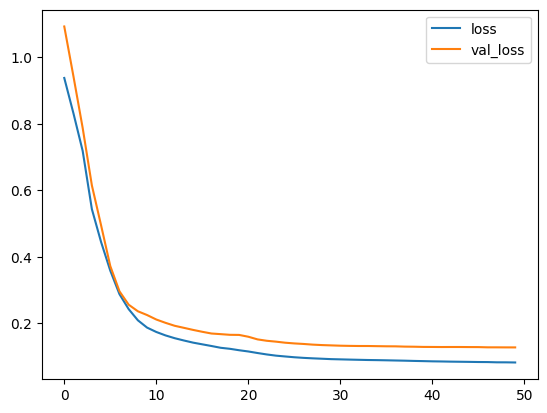

In [ ]:
# Write your code here. Add as many boxes as you need.
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

Use the trained model to make predictions for the test set.

In [ ]:
X_test = X_test.reshape(X_test.shape[0], 3, 4)


In [ ]:
# Write your code here. Add as many boxes as you need.
preds = model.predict(X_test)

14/14 [==============================] - 0s 2ms/step


Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [ ]:
# Write your code here. Add as many boxes as you need.
preds = scaler.inverse_transform(preds)

In [ ]:
mean_squared_error(preds, Y_test), mean_absolute_error(preds, Y_test), r2_score(preds, Y_test)

(0.23918024663980136, 0.36189619979241705, 0.8064644665868926)

Create a line plot in order to compare the actual and predicted mean temperatures for the test set.

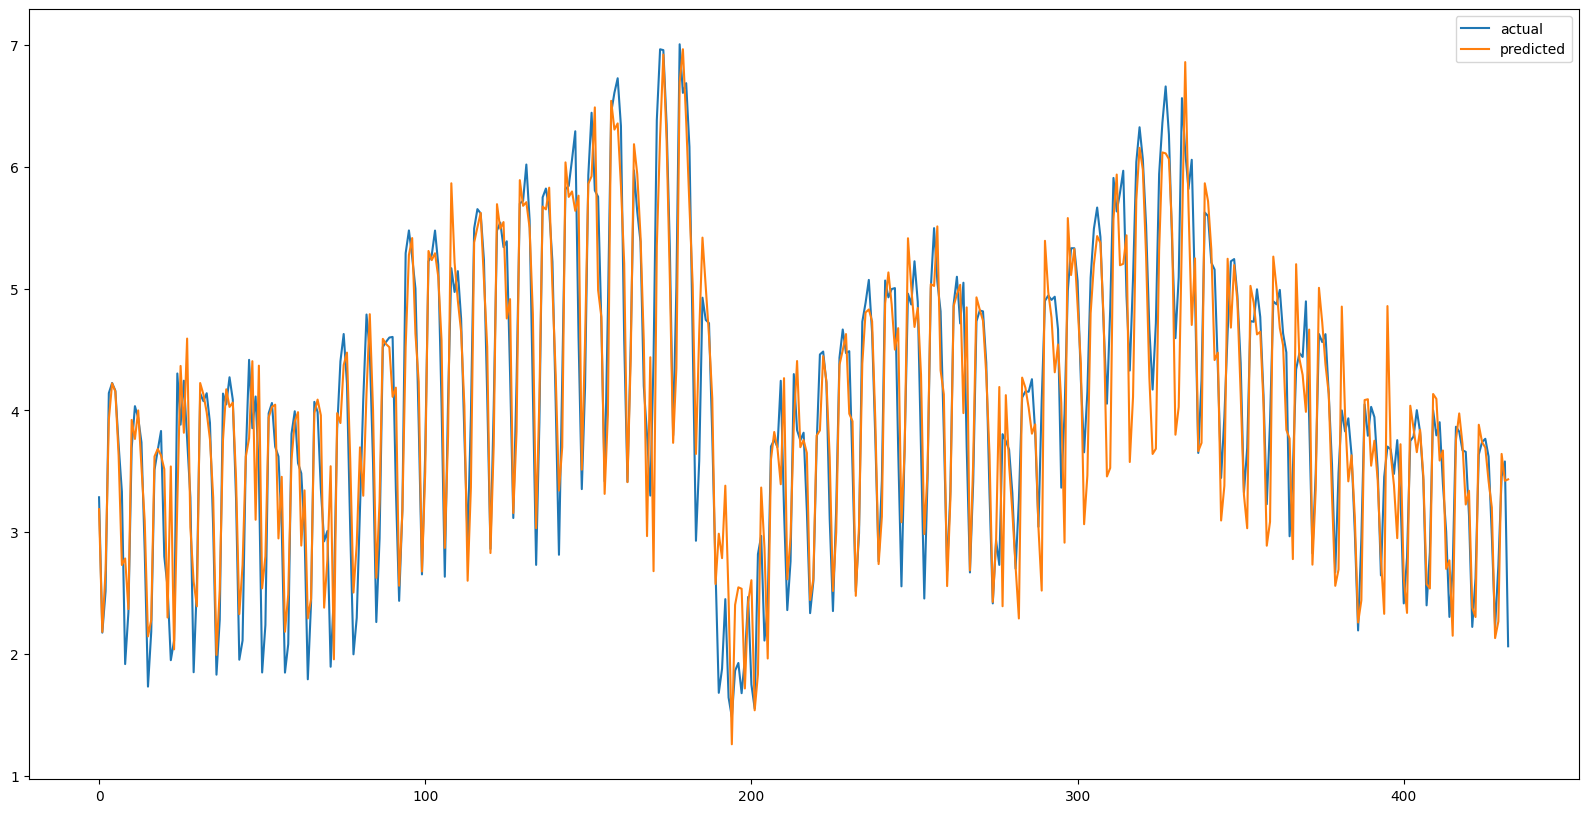

In [ ]:
# Write your code here. Add as many boxes as you need.
plt.figure(figsize=(20, 10))
plt.plot(Y_test.values, label='actual')
plt.plot(preds, label='predicted')
plt.legend()
plt.show()

# Laboratory Exercise - Bonus Task (+ 2 points)

As part of the bonus task in this laboratory assignment, your objective is to perform a sentiment analysis on a dataset consisting of wine reviews. The dataset contains two attributes: **description** and **points**. The description is a brief text describing the wine and the points which represents a quality metric ranging from 1 to 100. If some wine has at least 90 points it is considered **exceptional**. Your task involves predicting if some wine is exceptional based on its review.

The greater part of the code for the solution is already given. You need to define a tokenizer to tokenize the given texts and a deep neural network model that will be used for the classification task at hand. Fill in only the missing code blocks.

## Requirements

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
import keras
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Downloading the Wine Reviews Dataset

In [ ]:
!gdown 1fz9449M9Owofy6CYrKzkGwXKesI32B8u

Downloading...
From: https://drive.google.com/uc?id=1fz9449M9Owofy6CYrKzkGwXKesI32B8u
To: /content/wine-reviews.csv
100% 32.5M/32.5M [00:00<00:00, 112MB/s]


## Exploring the Climate Dataset

Load the dataset into a `pandas` data frame.

In [ ]:
df = pd.read_csv('wine-reviews.csv')

In [ ]:
df.head()

,description,points
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


## Feature Extraction

Extract the feature `exceptional` for each wine review.

In [ ]:
df['exceptional'] = df['points'].apply(lambda elem: 1 if elem >= 90 else 0)

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

In [ ]:
X, Y = df['description'], df['exceptional']

In [ ]:
Y = pd.get_dummies(df['exceptional'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

## Text Tokenization

Use tokenizer to convert raw text into a sequence of tokens.

In [ ]:
# Write your code here. Add as many boxes as you need.
max_tokens = 64

In [ ]:
tokenizer = Tokenizer(num_words=max_tokens)
tokenizer.fit_on_texts(X_train.values)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
 len_tokens = [len(token_list) for token_list in X_train]

(array([1.8000e+01, 2.5400e+02, 1.5200e+03, 5.2870e+03, 1.2524e+04,
        2.0016e+04, 2.2088e+04, 1.8733e+04, 1.2192e+04, 6.5500e+03,
        3.5280e+03, 7.9400e+02, 3.0800e+02, 9.7000e+01, 3.7000e+01,
        1.5000e+01, 8.0000e+00, 4.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([ 0. ,  3.1,  6.2,  9.3, 12.4, 15.5, 18.6, 21.7, 24.8, 27.9, 31. ,
        34.1, 37.2, 40.3, 43.4, 46.5, 49.6, 52.7, 55.8, 58.9, 62. ]),
 <BarContainer object of 20 artists>)

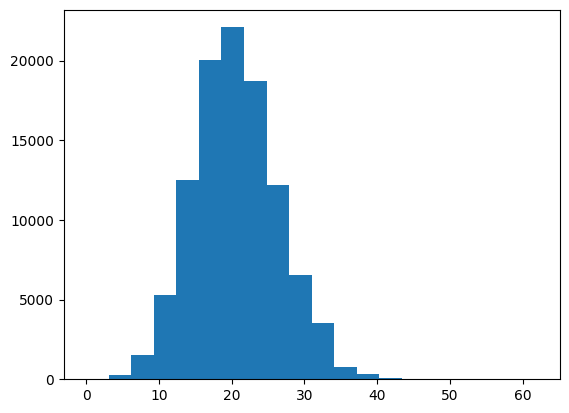

In [ ]:
plt.hist(len_tokens,bins=20)

In [ ]:
 maxlen=24
 np.average(len_tokens)

20.471378010310072

## Padding
Pad each sequence to maximum length of 16.

In [ ]:
# Write your code here. Add as many boxes as you need.
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

## Deep Neural Network

Define Deep Neural Network model to predict if a specific wine is exceptional or not based on the tokenized and padded wine reviews.

In [ ]:
# Write your code here. Add as many boxes as you need.
num_classes = len(Y.columns)

Compile the previously defined model specifying loss function, optimizer and evaluation metrics.

In [ ]:
# Write your code here. Add as many boxes as you need.\
model = Sequential()
model.add(Embedding(max_tokens, 32, input_length=X_train.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))

Fit the compiled model on the train set specifying the percent for validation, batch_size, and number of epochs.

In [ ]:
# Write your code here. Add as many boxes as you need.
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=64, epochs=10)

Epoch 1/10
1300/1300 [==============================] - 36s 25ms/step - loss: 0.5714 - precision: 0.7016 - recall: 0.7016 - val_loss: 0.5499 - val_precision: 0.7199 - val_recall: 0.7199
Epoch 2/10
1300/1300 [==============================] - 30s 23ms/step - loss: 0.5496 - precision: 0.7183 - recall: 0.7183 - val_loss: 0.5423 - val_precision: 0.7238 - val_recall: 0.7238
Epoch 3/10
1300/1300 [==============================] - 30s 23ms/step - loss: 0.5394 - precision: 0.7239 - recall: 0.7239 - val_loss: 0.5381 - val_precision: 0.7272 - val_recall: 0.7272
Epoch 4/10
1300/1300 [==============================] - 30s 23ms/step - loss: 0.5309 - precision: 0.7318 - recall: 0.7318 - val_loss: 0.5397 - val_precision: 0.7260 - val_recall: 0.7260
Epoch 5/10
1300/1300 [==============================] - 31s 24ms/step - loss: 0.5253 - precision: 0.7348 - recall: 0.7348 - val_loss: 0.5385 - val_precision: 0.7258 - val_recall: 0.7258
Epoch 6/10
1300/1300 [==============================] - 31s 23ms/step 

Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

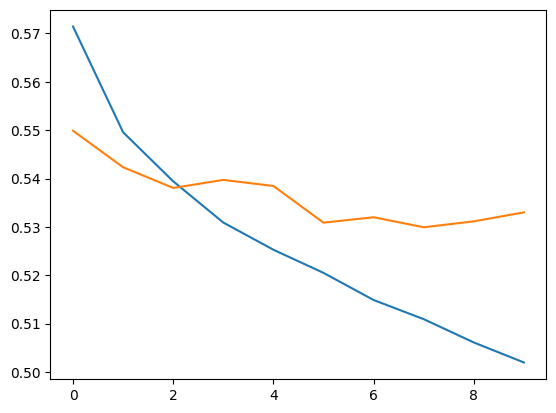

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.show()

Use the trained model to make predictions for the test set.

In [ ]:
y_pred = model.predict(X_test)

813/813 [==============================] - 4s 4ms/step


Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [ ]:
print(classification_report(y_test, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.74      0.86      0.80     16078
           1       0.70      0.51      0.59      9917

   micro avg       0.73      0.73      0.73     25995
   macro avg       0.72      0.69      0.69     25995
weighted avg       0.73      0.73      0.72     25995
 samples avg       0.73      0.73      0.73     25995

